## Mini Jupyter Exercise #4

### Train and Test Split

In [1]:
from sklearn.datasets import load_digits
images, labels = load_digits(2, return_X_y=True)

# Labeled training set
training_images = images[:300]
training_labels = labels[:300]

# Labeled test set
test_images = images[300:]
test_labels = labels[300:]

### k-Nearest Neighbor (k-NN) Classification Using 2-D Features

#### Problem 1: Computing of the Top-two Principal Components and Two-dimensional (Training) Feature Vectors

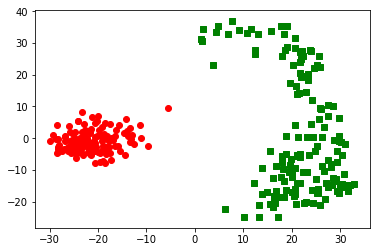

In [3]:
import numpy as np
from matplotlib import pyplot as plt

# Arranging training data so that each sample is a column in the data matrix
X = training_images.T # Data matrix

# Computation of the empirical mean of data, both as a vector and as a tiled matrix
mean_vec = X.mean(axis = 1)
mean_mat = np.tile(mean_vec.reshape(X.shape[0],1),[1,X.shape[1]])

# Centered data matrix
centered_X = X - mean_mat

# Singular value decomposition of centered data
U, s, Vh = np.linalg.svd(centered_X)

# Matrix of the top two principal components of the centered data matrix
U_2 = U[:,0:2]

# Compute the PCA-based features of the centered data using the top-two principal components
X_tilde = U_2.T@centered_X

# Scatter plot for digits '0' and '1' using the two-dimensional PCA features
plt.scatter(X_tilde.T[np.where(training_labels==0),0],X_tilde.T[np.where(training_labels==0),1],c='r',marker='o')
plt.scatter(X_tilde.T[np.where(training_labels==1),0],X_tilde.T[np.where(training_labels==1),1],c='g',marker='s')
plt.show()

#### Problem 2: Computing of Two-dimensional Feature Vectors for Test Data

In [4]:
# Arranging test data so that each sample is a column in the data matrix
X_test = test_images.T

# Appropriate shaping of the empirical mean as a tiled matrix whose dimensions match those of test data matrix
mean_mat = np.tile(mean_vec.reshape(X_test.shape[0],1),[1,X_test.shape[1]])

# Centered test data matrix
centered_X_test = X_test - mean_mat

# Compute the PCA-based features of the centered test data using the top-two principal components
X_tilde_test = U_2.T@centered_X_test

#### Classification of Test Data Using k-NN (k=5)

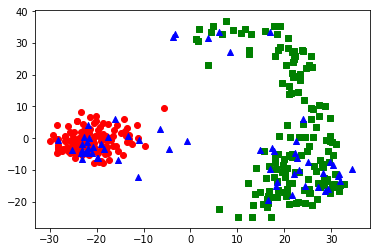

In [5]:
def kNN_clf(X, X_labels, k, test_x):
    """
    k-Nearest Neigbor classifer that returns either label '0' or label '1'
    Inputs: 
        X: Training data matrix
        X_labels: Labels for the training data matrix
        k: Number of nearest neighbors in k-NN (Euclidean distance)
        test_x: Test sample
    Ouput: test_label: Estimated label for test_x 
    """
    # Compute distances between all training samples and the test sample
    dist = np.array([np.linalg.norm(test_x - X[:,i]) for i in range(X.shape[1])])
    
    # Sort the distances and find the indices of the k-NNs
    sorted_dist_ind = dist.argsort() # Sorting
    kNN_labels = X_labels[sorted_dist_ind[0:k]] # Indices
    
    # Return the label that occurs most frequently within the k-NNs
    if np.size(np.where(kNN_labels==0)) >= np.size(np.where(kNN_labels==1)):
        return 0
    else:
        return 1
    
# Estimated labels returned by the k-NN classifier
est_labels = np.array([kNN_clf(X_tilde,training_labels,5,X_tilde_test[:,i]) for i in range(X_tilde_test.shape[1])])

# Accuracy of the predicted labels
acc_label = np.equal(est_labels,test_labels)

# Scatter plot for training digits '0' and '1' using the two-dimensional PCA features
plt.scatter(X_tilde.T[np.where(training_labels==0),0],X_tilde.T[np.where(training_labels==0),1],c='r',marker='o')
plt.scatter(X_tilde.T[np.where(training_labels==1),0],X_tilde.T[np.where(training_labels==1),1],c='g',marker='s')

# Scatter plot for test digits '0' and '1,' coded as 'blue' for correct classification and 'black' for incorrect classification
plt.scatter(X_tilde_test.T[np.where(acc_label==True),0],X_tilde_test.T[np.where(acc_label==True),1],c='b',marker='^')
plt.scatter(X_tilde_test.T[np.where(acc_label==False),0],X_tilde_test.T[np.where(acc_label==False),1],c='k',marker='d')
plt.show()

We can see from the above scatter plot, which overlays the test two-dimensional data on top of the training two-dimensional data that the top-two principal components of the data are sufficient to separate digits '0' and '1' in the PCA space. In particular, using $k=5$ results in zero classification errors.

#### Problem 3: Computation of the Average Classification Error

In [6]:
from IPython.display import display, Latex

# Calculation of the average classification error
ave_clf_err = (np.size(np.where(acc_label==False)))/acc_label.size

# Printing of the average classification error
display(Latex(r'The average classification error for this $k$-NN problem using $k=5$ is {}.'.format(ave_clf_err)))

<IPython.core.display.Latex object>

### k-NN Classification Using Higher-dimensional Features

#### Problem 1: Feature Learning of Training and Test Data

We have already centered the (training) data and computed its singular value decomposition. At this stage, we simply need to find out the value of $r$ that captures 95\% of the variation in the data.

In [7]:
# Computation of an appropriate 'r'
r = 0; cum_sum = 0
data_energy = np.linalg.norm(centered_X)**2
for i in range(len(s)):
    cum_sum = cum_sum + s[i]**2
    if cum_sum/data_energy >= 0.95:
        r = i+1
        break
        
# Print the value of r
display(Latex(r'The calculated value of the integer $r$ is {}.'.format(r)))

# Matrix of the top-r principal components of the centered data matrix
U_r = U[:,0:r]

# Compute the PCA-based features of the centered data using the top-r principal components
X_tilde = U_r.T@centered_X

# Compute the PCA-based features of the centered test data using the top-r principal components
X_tilde_test = U_r.T@centered_X_test

<IPython.core.display.Latex object>

#### Problem 2: Classification Using k-NN and Selection of the "Best" k

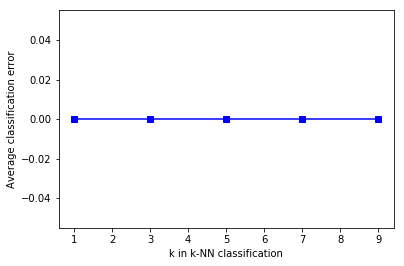

In [8]:
# The values of k that need to be tried for k-NN classification
k = np.array([i for i in range(1,10,2)])

# Container for average classification errors as a function of k
ave_clf_err = np.empty(k.size)

# k-NN classification
for idx, val_k in zip(range(k.size),k):
    # Estimated labels returned by the k-NN classifier
    est_labels = np.array([kNN_clf(X_tilde,training_labels,val_k,X_tilde_test[:,i]) for i in range(X_tilde_test.shape[1])])
    # Accuracy of the predicted labels
    acc_label = np.equal(est_labels,test_labels)
    # Calculation of the average classification error
    ave_clf_err[idx] = (np.size(np.where(acc_label==False)))/acc_label.size
    
# Plot of the average classification error as a function of the values of k
plt.plot(k, ave_clf_err, 'b-s')
plt.xlabel('k in k-NN classification')
plt.ylabel('Average classification error')
plt.show()

We can see from the above classification error plot that even $k=1$ is sufficient to perfectly distinguish between digits '0' and '1' in $r=19$ dimensional PCA space. We can therefore limit oursleves to $k=1$ for $k$-NN classification for this particular problem setup.

**_Caution:_** We learned about the concept of cross-validation in a future class, which is what we should really be using to determine the right value of $k$ in practical machine learning systems.